# Tracking Failure Origins

To identify the origin of a failure, one proceeds along _dependencies_: Which earlier variables could possibly have influenced the current erroneous state? And how did their values come to be? In this chapter, we show how to identify these dependencies, and how to automatically compute them.

In [1]:
from bookutils import YouTubeVideo
# YouTubeVideo("w4u5gCgPlmg")

**Prerequisites**

* You should have read the [Introduction to Debugging](Intro_Debugging).
* To understand how to compute dependencies automatically, advanced knowledge of Python is required.

In [2]:
import bookutils

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.Slicer import <identifier>
```

and then make use of the following features.


_For those only interested in using the code in this chapter (without wanting to know how it works), give an example.  This will be copied to the beginning of the chapter (before the first section) as text with rendered input and output._



## Dependencies

We start with a simple program. The `middle()` function is supposed to return the "middle" number of three values `x`, `y`, and `z` – that is, the one number that neither is the minimum nor the maximum.

In [3]:
def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return y
    else:
        if x > y:
            return y
        elif x > z:
            return x
    return z

In most cases, `middle()` runs just fine:

In [4]:
m = middle(1, 2, 3)
m

2

In others, however, it returns the wrong value:

In [5]:
m = middle(2, 1, 3)
m

1

This is a typical debugging situation: You see a value that is erroneous; and you want to find out where it came from. 

In [6]:
class Dependencies(object):
    def __init__(self, data, control):
        self.data = data
        self.control = control

    def validate(self):
        pass

## Drawing Dependencies

In [7]:
from graphviz import Digraph, nohtml

In [8]:
import html

In [9]:
import inspect

In [10]:
class Dependencies(Dependencies):
    def source(self, var):
        (name, location) = var
        code_name, lineno = location
        fun = globals()[code_name]
        source_lines, first_lineno = inspect.getsourcelines(fun)

        try:
            line = source_lines[lineno - first_lineno].strip()
        except IndexError:
            line = ''

        return line

In [11]:
class Dependencies(Dependencies):
    NODE_COLOR = 'peachpuff'
    FONT_NAME = 'Fira Mono'

    def make_graph(self, name="dependencies", comment="Dependencies"):
        return Digraph(name=name, comment=comment, 
            graph_attr={
            },
            node_attr={
                'style': 'filled',
                'shape': 'box',
                'fillcolor': self.NODE_COLOR,
                'fontname': self.FONT_NAME
            },
            edge_attr={
                'fontname': self.FONT_NAME
            })

In [12]:
class Dependencies(Dependencies):
    def id(self, var):
        id = ""
        for c in repr(var):
            if c.isalnum() or c == '_':
                id += c
            if c == ':' or c == ',':
                id += '_'
        return id

    def label(self, var):
        (name, location) = var
        source = self.source(var)

        title = html.escape(name)
        if name.startswith('<'):
            title = f'<I>{title}</I>'

        return (f'<'
                f'<B>{title}</B>'
                f'<FONT POINT-SIZE="9.0"><BR/><BR/>'
                f'{html.escape(source)}'
                f'</FONT>'
                f'>')

    def tooltip(self, var):
        (name, location) = var
        code_name, lineno = location
        return f"{code_name}:{lineno}"

In [13]:
class Dependencies(Dependencies):
    def graph(self):
        """Draw dependencies."""
        self.validate()

        g = self.make_graph()
        self.draw_dependencies(g)
        self.add_hierarchy(g)
        return g

In [14]:
class Dependencies(Dependencies):
    def draw_dependencies(self, g):
        for var in self.data:
            g.node(self.id(var), 
                   label=self.label(var),
                   tooltip=self.tooltip(var))

            for source in self.data[var]:
                g.edge(self.id(source), self.id(var))

            for source in self.control[var]:
                g.edge(self.id(source), self.id(var),
                       style='dashed', color='grey')

In [15]:
class Dependencies(Dependencies):
    def all_vars(self):
        all_vars = set()
        for var in self.data:
            all_vars.add(var)

            for source in self.data[var]:
                all_vars.add(source)

            for source in self.control[var]:
                all_vars.add(source)

        return all_vars

In [16]:
class Dependencies(Dependencies):
    def all_codes(self):
        code_names = {}
        for var in self.all_vars():
            (name, location) = var
            code_name, lineno = location
            if code_name not in code_names:
                code_names[code_name] = []
            code_names[code_name].append((lineno, var))

        for code_name in code_names:
            code_names[code_name].sort()

        return code_names

In [17]:
class Dependencies(Dependencies):
    def add_hierarchy(self, g):
        """Add invisible edges for a proper hierarchy."""
        code_names = self.all_codes()
        for code_name in code_names:
            last_var = None
            last_lineno = 0
            for (lineno, var) in code_names[code_name]:
                if last_var is not None and lineno > last_lineno:
                    g.edge(self.id(last_var),
                           self.id(var),
                           style='invis')

                last_var = var
                last_lineno = lineno

        return g

In [18]:
class Dependencies(Dependencies):
    def expand_items(self, items):
        all_items = []
        for item in items:
            if isinstance(item, str):
                for var in self.all_vars():
                    (name, location) = var
                    if name == item:
                        all_items.append(var)
            else:
                all_items.append(item)

        return all_items

    def backward_slice(self, *items, mode="cd"):
        data = {}
        control = {}
        queue = self.expand_items(items)
        seen = set()

        while len(queue) > 0:
            var = queue[0]
            queue = queue[1:]
            seen.add(var)

            if 'd' in mode:
                data[var] = self.data[var]
                for next_var in data[var]:
                    if next_var not in seen:
                        queue.append(next_var)
            else:
                data[var] = set()

            if 'c' in mode:
                control[var] = self.control[var]
                for next_var in control[var]:
                    if next_var not in seen:
                        queue.append(next_var)
            else:
                control[var] = set()

        return Dependencies(data, control)

In [19]:
from bookutils import print_content

In [20]:
class Dependencies(Dependencies):
    def format_var(self, var, current_location=None):
        name, location = var
        location_name, lineno = location
        if location_name != current_location:
            return f"{name} ({location_name}:{lineno})"
        else:
            return f"{name} ({lineno})"

In [21]:
class Dependencies(Dependencies):
    def __str__(self):
        self.validate()

        out = ""
        for code_name in self.all_codes():
            if out != "":
                out += "\n"
            out += f"{code_name}():\n"

            all_vars = list(set(self.data.keys()) | set(self.control.keys()))
            all_vars.sort(key=lambda var: var[1][1])

            for var in all_vars:
                (name, location) = var
                var_code, var_lineno = location
                if var_code != code_name:
                    continue

                all_deps = ""
                for (source, arrow) in [(self.data, "<="), (self.control, "<-")]:
                    deps = ""
                    for data_dep in source[var]:
                        if deps == "":
                            deps = f" {arrow} "
                        else:
                            deps += ", "
                        deps += self.format_var(data_dep, code_name)

                    if deps != "":
                        if all_deps != "":
                            all_deps += ";"
                        all_deps += deps

                if all_deps == "":
                    continue

                out += ("    " + 
                        self.format_var(var, code_name) +
                        all_deps + "\n")

        return out

    def __repr__(self):
        # Useful for saving and restoring values
        return f"Dependencies({self.data}, {self.control})"

In [22]:
class Dependencies(Dependencies):
    def code(self, item, mode='cd'):
        all_vars = self.all_vars()
        slice_locations = set(location for name, location in all_vars)

        source_lines, first_lineno = inspect.getsourcelines(item)

        n = first_lineno
        for line in source_lines:
            line_location = (item.__name__, n)
            if line_location in slice_locations:
                prefix = "* "
            else:
                prefix = "  "

            print(f"{prefix}{n:4} ", end="")

            comment = ""
            for (mode_control, source, arrow) in [
                ('d', self.data, '<='),
                ('c', self.control, '<-')
            ]:
                if mode_control not in mode:
                    continue

                deps = ""
                for var in source:
                    name, location = var
                    if location == line_location:
                        for dep_var in source[var]:
                            if deps == "":
                                deps = arrow + " "
                            else:
                                deps += ", "
                            deps += self.format_var(dep_var, item.__name__)

                if deps != "":
                    if comment != "":
                        comment += "; "
                    comment += deps

            if comment != "":
                line = line.rstrip() + "  # " + comment

            print_content(line.rstrip(), '.py')
            print()
            n += 1

In [23]:
middle_deps = Dependencies({('z', ('middle', 1)): set(), ('y', ('middle', 1)): set(), ('x', ('middle', 1)): set(), ('<test>', ('middle', 2)): {('y', ('middle', 1)), ('z', ('middle', 1))}, ('<test>', ('middle', 3)): {('y', ('middle', 1)), ('x', ('middle', 1))}, ('<test>', ('middle', 5)): {('z', ('middle', 1)), ('x', ('middle', 1))}, ('<middle() return value>', ('middle', 6)): {('y', ('middle', 1))}}, {('z', ('middle', 1)): set(), ('y', ('middle', 1)): set(), ('x', ('middle', 1)): set(), ('<test>', ('middle', 2)): set(), ('<test>', ('middle', 3)): {('<test>', ('middle', 2))}, ('<test>', ('middle', 5)): {('<test>', ('middle', 3))}, ('<middle() return value>', ('middle', 6)): {('<test>', ('middle', 5))}})

### Data Dependencies

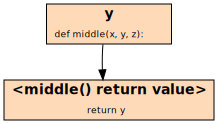

In [24]:
middle_deps.backward_slice('<middle() return value>', mode='d').graph()

### Control Dependencies

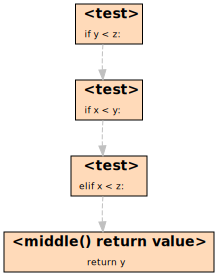

In [25]:
middle_deps.backward_slice('<middle() return value>', mode='c').graph()

### All Dependencies

In [26]:
print(middle_deps)

middle():
    <test> (2) <= y (1), z (1)
    <test> (3) <= x (1), y (1); <- <test> (2)
    <test> (5) <= x (1), z (1); <- <test> (3)
    <middle() return value> (6) <= y (1); <- <test> (5)



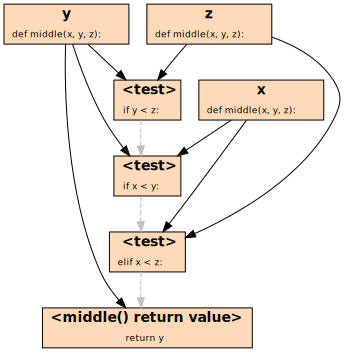

In [27]:
middle_deps.graph()

### Slices

In [28]:
middle_deps.code(middle)

*    1 def middle(x, y, z):
*    2     if y < z:  # <= y (1), z (1)
*    3         if x < y:  # <= x (1), y (1); <- <test> (2)
     4             return y
*    5         elif x < z:  # <= x (1), z (1); <- <test> (3)
*    6             return y  # <= y (1); <- <test> (5)
     7     else:
     8         if x > y:
     9             return y
    10         elif x > z:
    11             return x
    12     return z


## Instrumenting Code

In [29]:
import ast
import astor

In [30]:
from bookutils import rich_output

In [31]:
if rich_output():
    from showast import show_ast
else:
    def show_ast(tree):
        ast.dump(tree)

In [32]:
import math

In [33]:
import inspect

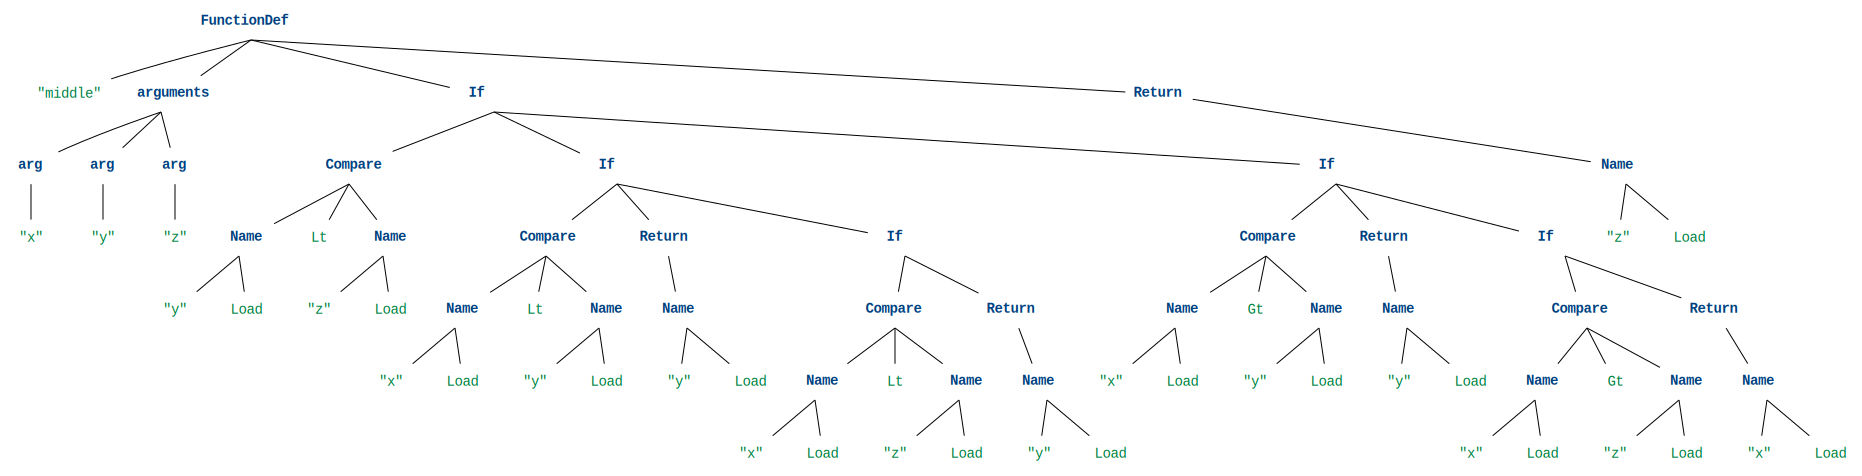

In [34]:
middle_tree = ast.parse(inspect.getsource(middle))
show_ast(middle_tree)

In [35]:
from ast import NodeTransformer, Subscript, Name, Load, Store, \
    Assign, Attribute, With, withitem, Return, Index, Str, Call, Expr

In [36]:
DATA_STORE = '_data'

In [37]:
print(ast.dump(ast.parse(f"{DATA_STORE}['x']")))

Module(body=[Expr(value=Subscript(value=Name(id='_data', ctx=Load()), slice=Index(value=Str(s='x')), ctx=Load()))])


In [38]:
def make_data_access(id, ctx):
    return Subscript(
        value=Name(id=DATA_STORE, ctx=Load()),
        slice=Index(value=Str(s=id)),
        ctx=ctx
    )

In [39]:
class TrackAccessTransformer(NodeTransformer):
    def visit_Name(self, node):
        if node.id in dir(__builtins__):
            return node  # Do not change built-in names
        return make_data_access(node.id, node.ctx)

In [40]:
def dump_tree(tree):
    ast.fix_missing_locations(tree)
    print(astor.to_source(tree))
    code = compile(tree, '<string>', 'exec')

In [41]:
TrackAccessTransformer().visit(middle_tree)
dump_tree(middle_tree)

def middle(x, y, z):
    if _data['y'] < _data['z']:
        if _data['x'] < _data['y']:
            return _data['y']
        elif _data['x'] < _data['z']:
            return _data['y']
    elif _data['x'] > _data['y']:
        return _data['y']
    elif _data['x'] > _data['z']:
        return _data['x']
    return _data['z']



### Excursion: More Transformations

In [42]:
print(ast.dump(ast.parse(f"{DATA_STORE}.param('x', x)")))

Module(body=[Expr(value=Call(func=Attribute(value=Name(id='_data', ctx=Load()), attr='param', ctx=Load()), args=[Str(s='x'), Name(id='x', ctx=Load())], keywords=[]))])


In [43]:
class TrackParamsTransformer(NodeTransformer):
    def visit_FunctionDef(self, node):
        self.generic_visit(node)

        named_args = []
        for child in ast.iter_child_nodes(node.args):
            if isinstance(child, ast.arg):
                named_args.append(child.arg)

        create_stmts = []
        for arg in named_args:
            create_stmt = Expr(
                value=Call(
                    func=Attribute(value=Name(id=DATA_STORE, ctx=Load()),
                                   attr='param', ctx=Load()),
                    args=[Str(s=arg), Name(id=arg, ctx=Load())],
                    keywords=[]
                )
            )
            create_stmts.append(create_stmt)
        create_stmts.reverse()

        node.body = create_stmts + node.body
        return node

In [44]:
TrackParamsTransformer().visit(middle_tree)
dump_tree(middle_tree)

def middle(x, y, z):
    _data.param('z', z)
    _data.param('y', y)
    _data.param('x', x)
    if _data['y'] < _data['z']:
        if _data['x'] < _data['y']:
            return _data['y']
        elif _data['x'] < _data['z']:
            return _data['y']
    elif _data['x'] > _data['y']:
        return _data['y']
    elif _data['x'] > _data['z']:
        return _data['x']
    return _data['z']



In [45]:
class TrackReturnTransformer(NodeTransformer):
    def __init__(self):
        self.function_name = None
        super().__init__()

    def visit_FunctionDef(self, node):
        self.function_name = node.name
        self.generic_visit(node)
        return node

    def return_value(self):
        if self.function_name is None:
            return "<return value>"
        else:
            return f"<{self.function_name}() return value>"

    def visit_Return(self, node):
        assign_node = Assign(
                targets=[make_data_access(self.return_value(), Store())],
                value=node.value
            )
        return_node = Return(
                value=make_data_access(self.return_value(), Load())
            )
        ast.copy_location(assign_node, node)
        ast.copy_location(return_node, node)

        return [
            assign_node,
            return_node
        ]

In [46]:
TrackReturnTransformer().visit(middle_tree)
dump_tree(middle_tree)

def middle(x, y, z):
    _data.param('z', z)
    _data.param('y', y)
    _data.param('x', x)
    if _data['y'] < _data['z']:
        if _data['x'] < _data['y']:
            _data['<middle() return value>'] = _data['y']
            return _data['<middle() return value>']
        elif _data['x'] < _data['z']:
            _data['<middle() return value>'] = _data['y']
            return _data['<middle() return value>']
    elif _data['x'] > _data['y']:
        _data['<middle() return value>'] = _data['y']
        return _data['<middle() return value>']
    elif _data['x'] > _data['z']:
        _data['<middle() return value>'] = _data['x']
        return _data['<middle() return value>']
    _data['<middle() return value>'] = _data['z']
    return _data['<middle() return value>']



In [47]:
class TrackControlTransformer(NodeTransformer):
    def make_with(self, block):
        if len(block) == 0:
            return []

        return [With(
            items=[
                withitem(
                    context_expr=Name(id=DATA_STORE, ctx=Load()),
                    optional_vars=None)
            ],
            body=block
        )]

    def make_test(self, test):
        return Call(func=Attribute(value=Name(id=DATA_STORE, ctx=Load()),
                                   attr='test',
                                   ctx=Load()),
                     args=[test],
                     keywords=[])

    def visit_If(self, node):
        self.generic_visit(node)
        node.test = self.make_test(node.test)
        node.body = self.make_with(node.body)
        node.orelse = self.make_with(node.orelse)
        return node

    def visit_While(self, node):
        self.generic_visit(node)
        node.test = self.make_test(node.test)
        node.body = self.make_with(node.body)
        node.orelse = self.make_with(node.orelse)
        return node

    def visit_For(self, node):
        self.generic_visit(node)
        node.body = self.make_with(node.body)
        node.orelse = self.make_with(node.orelse)
        return node

In [48]:
TrackControlTransformer().visit(middle_tree)
dump_tree(middle_tree)

def middle(x, y, z):
    _data.param('z', z)
    _data.param('y', y)
    _data.param('x', x)
    if _data.test(_data['y'] < _data['z']):
        with _data:
            if _data.test(_data['x'] < _data['y']):
                with _data:
                    _data['<middle() return value>'] = _data['y']
                    return _data['<middle() return value>']
            else:
                with _data:
                    if _data.test(_data['x'] < _data['z']):
                        with _data:
                            _data['<middle() return value>'] = _data['y']
                            return _data['<middle() return value>']
    else:
        with _data:
            if _data.test(_data['x'] > _data['y']):
                with _data:
                    _data['<middle() return value>'] = _data['y']
                    return _data['<middle() return value>']
            else:
                with _data:
                    if _data.test(_data['x'] > _data['z']):
           

In [49]:
class TrackCallTransformer(NodeTransformer):
    def make_call(self, node, fun):
        return Call(func=Attribute(value=Name(id=DATA_STORE,
                                              ctx=Load()),
                                   attr=fun,
                                   ctx=Load()),
                     args=[node],
                     keywords=[])

    def visit_Call(self, node):
        self.generic_visit(node)

        new_args = []
        for arg in node.args:
            new_args.append(self.make_call(arg, 'arg'))
        node.args = new_args

        for kw in node.keywords:
            kw.value = self.make_call(kw.value, 'arg')

        node.func = self.make_call(node.func, 'call')
        return self.make_call(node, 'ret')

In [50]:
def test_call():
    x = middle(1, 2, middle(1, 2, 3))

In [51]:
call_tree = ast.parse(inspect.getsource(test_call))
dump_tree(call_tree)

def test_call():
    x = middle(1, 2, middle(1, 2, 3))



In [52]:
TrackCallTransformer().visit(call_tree)
dump_tree(call_tree)

def test_call():
    x = _data.ret(_data.call(middle)(_data.arg(1), _data.arg(2), _data.arg(
        _data.ret(_data.call(middle)(_data.arg(1), _data.arg(2), _data.arg(
        3))))))



In [53]:
def print_ast_ids(tree):
    for node in ast.walk(tree):
        print(node)
        try:
            print(astor.to_source(node))
        except AttributeError:
            print("(No source)\n")

In [54]:
# print_ast_ids(new_square_root_tree)

### End of Excursion

In [55]:
dump_tree(middle_tree)

def middle(x, y, z):
    _data.param('z', z)
    _data.param('y', y)
    _data.param('x', x)
    if _data.test(_data['y'] < _data['z']):
        with _data:
            if _data.test(_data['x'] < _data['y']):
                with _data:
                    _data['<middle() return value>'] = _data['y']
                    return _data['<middle() return value>']
            else:
                with _data:
                    if _data.test(_data['x'] < _data['z']):
                        with _data:
                            _data['<middle() return value>'] = _data['y']
                            return _data['<middle() return value>']
    else:
        with _data:
            if _data.test(_data['x'] > _data['y']):
                with _data:
                    _data['<middle() return value>'] = _data['y']
                    return _data['<middle() return value>']
            else:
                with _data:
                    if _data.test(_data['x'] > _data['z']):
           

## Tracking Data

In [56]:
class DataStore(dict):
    def __init__(self, *args, log=False):
        super().__init__(*args)
        self.log = log

    def caller_location(self):
        frame = inspect.currentframe()
        while ('self' in frame.f_locals and 
               isinstance(frame.f_locals['self'], self.__class__)):
               frame = frame.f_back
        return frame.f_code.co_name, frame.f_lineno

    def __getitem__(self, name):
        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: getting {name}")

        if name in self:
            return super().__getitem__(name)
        else:
            return globals()[name]

    def __setitem__(self, name, value):
        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: setting {name}")

        return super().__setitem__(name, value)

In [57]:
class DataStore(DataStore):
    def test(self, cond):
        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: testing condition")

        return cond

    def param(self, name, value):
        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: initializing {name}")

        return self.__setitem__(name, value)

    def arg(self, value):
        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: pushing arg")

        return value

In [58]:
class DataStore(DataStore):
    def ret(self, value):
        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: returned from call")

        return value

In [59]:
class DataStore(DataStore):
    def call(self, fun):
        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: calling {fun}")

        return fun

In [60]:
class DataStore(DataStore):
    def __repr__(self):
        return super().__repr__()

    def __enter__(self):
        pass

    def __exit__(self, exc_type, exc_value, traceback):
        pass

In [61]:
_data = DataStore(log=True)

In [62]:
middle_code = compile(middle_tree, '<string>', 'exec')

In [63]:
original_middle = middle

In [64]:
print_content(inspect.getsource(middle), '.py', start_line_number=1)

 1  def middle(x, y, z):
 2      if y < z:
 3          if x < y:
 4              return y
 5          elif x < z:
 6              return y
 7      else:
 8          if x > y:
 9              return y
10          elif x > z:
11              return x
12      return z

In [65]:
exec(middle_code, globals())
middle(2, 1, 3)

middle:1: initializing z
middle:1: setting z
middle:1: initializing y
middle:1: setting y
middle:1: initializing x
middle:1: setting x
middle:2: getting y
middle:2: getting z
middle:2: testing condition
middle:3: getting x
middle:3: getting y
middle:3: testing condition
middle:5: getting x
middle:5: getting z
middle:5: testing condition
middle:6: getting y
middle:6: setting <middle() return value>
middle:6: getting <middle() return value>


1

In [66]:
del _data
del middle_code
middle = original_middle

In [67]:
middle(2, 1, 3)

1

## Tracking Dependencies

In [68]:
import itertools

In [69]:
class DataTracker(DataStore):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.origins = {}
        self.data_dependencies = {}
        self.control_dependencies = {}

        self.data = [[]]  # Data stack
        self.control = [[]]  # Control stack
        self.last_read = []
        self.last_checked_location = None
        self._ignore_location_change = False

        self.args = []  # Argument stack

In [70]:
class DataTracker(DataTracker):
    def clear_read(self):
        if self.log:
            direct_caller = inspect.currentframe().f_back.f_code.co_name
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: "
                  f"clearing read variables {self.last_read} "
                  f"(from {direct_caller})")

        self.last_read = []

    def check_location(self):
        location = self.caller_location()
        if self.last_checked_location != location:
            if self._ignore_location_change:
                self._ignore_location_change = False
            else:
                self.clear_read()

        self.last_checked_location = location

    def ignore_next_location_change(self):
        self._ignore_location_change = True

    def ignore_location_change(self):
        self.last_checked_location = self.caller_location()

    def __getitem__(self, name):
        self.check_location()
        self.last_read.append(name)
        return super().__getitem__(name)

In [71]:
class DataTracker(DataTracker):
    def __setitem__(self, name, value):
        def add_dependencies(dependencies, vars_read, tp):
            for var_read in vars_read:
                if var_read in self.origins:
                    origin = self.origins[var_read]
                    dependencies.add((var_read, origin))
                    if self.log:
                        origin_name, origin_lineno = origin
                        code_name, lineno = self.caller_location()
                        print(f"{code_name}:{lineno}: "
                              f"new {tp} dependency: "
                              f"{name} <= {var_read}@"
                              f"{origin_name}:{origin_lineno}")

        self.check_location()
        ret = super().__setitem__(name, value)
        location = self.caller_location()

        if (name, location) not in self.data_dependencies:
            self.data_dependencies[(name, location)] = set()
        if (name, location) not in self.control_dependencies:
            self.control_dependencies[(name, location)] = set()

        add_dependencies(self.data_dependencies[(name, location)],
                         self.last_read, tp="data")
        add_dependencies(self.control_dependencies[(name, location)],
                         itertools.chain.from_iterable(self.control),
                         tp="control")

        self.origins[name] = location

        # Reset read info for next line
        self.clear_read()

        return ret

In [72]:
class DataTracker(DataTracker):
    TEST = '<test>'

    def test(self, value):
        self.__setitem__(self.TEST, value)
        self.__getitem__(self.TEST)
        return super().test(value)

    def __enter__(self):
        self.control.append(self.last_read)
        self.clear_read()
        super().__enter__()

    def __exit__(self, exc_type, exc_value, traceback):
        self.clear_read()
        self.last_read = self.control.pop()
        self.ignore_next_location_change()
        super().__exit__(exc_type, exc_value, traceback)

    def dependencies(self):
        return Dependencies(self.data_dependencies,
                            self.control_dependencies)

In [73]:
class DataTracker(DataTracker):
    def call(self, fun):
        # Save context
        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: "
                  f"saving read variables {self.last_read}")

        self.data.append(self.last_read)
        self.clear_read()
        self.ignore_next_location_change()

        return super().call(fun)

    def ret(self, value):
        super().ret(value)

        # Restore old context and add return value
        ret_name = None
        for var in self.last_read:
            if var.startswith("<"):
                ret_name = var

        self.last_read = self.data.pop()
        self.last_read.append(ret_name)
        self.ignore_location_change()

        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: "
                  f"restored read variables {self.last_read}")

        return value

In [74]:
class DataTracker(DataTracker):
    def arg(self, value):
        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: "
                  f"saving arg reads {self.last_read}")

        self.args.append(self.last_read)
        self.clear_read()
        return super().arg(value)

    def param(self, name, value):
        self.clear_read()
        if self.args:
            self.last_read = self.args.pop()
            self.ignore_location_change()

        if self.log:
            code_name, lineno = self.caller_location()
            print(f"{code_name}:{lineno}: "
                  f"restored param {self.last_read}")

        return super().param(name, value)

#### Diagnostics

In [75]:
import re
import sys

In [76]:
class Dependencies(Dependencies):
    def validate(self):
        for var in self.all_vars():
            source = self.source(var)
            for dep_var in self.data[var] | self.control[var]:
                dep_name, dep_location = dep_var

                if dep_name == DataTracker.TEST:
                    continue

                if dep_name.endswith('return value>'):
                    if source.find('(') < 0:
                        print(f"Warning: {self.format_var(var)} "
                              f"depends on {self.format_var(dep_var)}, "
                              f"but {repr(source)} does not "
                              f"seem to have a call",
                              file=sys.stderr
                             )
                    continue

                if source.startswith('def'):
                    continue   # function call

                rx = re.compile(r'\b' + dep_name + r'\b')
                if rx.search(source) is None:
                    print(f"Warning: {self.format_var(var)} "
                          f"depends on {self.format_var(dep_var)}, "
                          f"but {repr(dep_name)} does not occur "
                          f"in {repr(source)}",
                          file=sys.stderr
                         )

## Slicing Code

In [77]:
class Instrumenter(object):
    def __init__(self, *items_to_instrument, log=False):
        self.log = log
        self.items_to_instrument = items_to_instrument

    def __enter__(self):
        """Instrument sources"""
        for item in self.items_to_instrument:
            self.instrument(item)
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        """Restore sources"""
        self.restore()

    def restore(self):
        for item in self.items_to_instrument:
            globals()[item.__name__] = item

    def instrument(self, item):
        if self.log:
            print("Instrumenting", item)

In [78]:
with Instrumenter(middle) as ins:
    pass

In [79]:
class Slicer(Instrumenter):
    def __init__(self, *items_to_instrument, 
                 data_tracker=None,
                 log=False):
        super().__init__(*items_to_instrument, log=log)
        if len(items_to_instrument) == 0:
            raise ValueError("Need one or more items to instrument")

        if data_tracker is None:
            data_tracker = DataTracker(log=(log > 1))
        self.data_tracker = data_tracker
        self.data_store = None

    def instrument(self, item):
        source_lines, lineno = inspect.getsourcelines(item)
        tree = ast.parse("".join(source_lines))
        ast.increment_lineno(tree, lineno - 1)

        TrackAccessTransformer().visit(tree)
        TrackCallTransformer().visit(tree)
        TrackControlTransformer().visit(tree)
        TrackReturnTransformer().visit(tree)
        TrackParamsTransformer().visit(tree)

        ast.fix_missing_locations(tree)
        # print_ast_ids(tree)

        if self.log:
            print(f"Instrumenting {item}:")

            if self.log > 1:
                n = lineno
                for line in source_lines:
                    print(f"{n:4} {line.rstrip()}")
                    n += 1
                print()

            print(astor.to_source(tree))

        code = compile(tree, '<string>', 'exec')
        exec(code, globals())
        globals()[DATA_STORE] = self.data_tracker

    def restore(self):
        if DATA_STORE in globals():
            self.data_store = globals()[DATA_STORE]
            del globals()[DATA_STORE]
        super().restore()

    def dependencies(self):
        if self.data_store is None:
            return Dependencies({}, {})
        return self.data_store.dependencies()

    def code(self, *args, **kwargs):
        first = True
        for item in self.items_to_instrument:
            if not first:
                print()
            self.dependencies().code(item, *args, **kwargs)
            first = False

    def graph(self, *args, **kwargs):
        return self.dependencies().graph(*args, **kwargs)

In [80]:
with Slicer(middle) as slicer:
    m = middle(2, 1, 3)
m

1

In [81]:
print(slicer.dependencies())

middle():
    <test> (2) <= y (1), z (1)
    <test> (3) <= x (1), y (1); <- <test> (2)
    <test> (5) <= x (1), z (1); <- <test> (3)
    <middle() return value> (6) <= y (1); <- <test> (5)



In [82]:
slicer.dependencies()

Dependencies({('z', ('middle', 1)): set(), ('y', ('middle', 1)): set(), ('x', ('middle', 1)): set(), ('<test>', ('middle', 2)): {('y', ('middle', 1)), ('z', ('middle', 1))}, ('<test>', ('middle', 3)): {('x', ('middle', 1)), ('y', ('middle', 1))}, ('<test>', ('middle', 5)): {('x', ('middle', 1)), ('z', ('middle', 1))}, ('<middle() return value>', ('middle', 6)): {('y', ('middle', 1))}}, {('z', ('middle', 1)): set(), ('y', ('middle', 1)): set(), ('x', ('middle', 1)): set(), ('<test>', ('middle', 2)): set(), ('<test>', ('middle', 3)): {('<test>', ('middle', 2))}, ('<test>', ('middle', 5)): {('<test>', ('middle', 3))}, ('<middle() return value>', ('middle', 6)): {('<test>', ('middle', 5))}})

In [83]:
slicer.code()

*    1 def middle(x, y, z):
*    2     if y < z:  # <= y (1), z (1)
*    3         if x < y:  # <= x (1), y (1); <- <test> (2)
     4             return y
*    5         elif x < z:  # <= x (1), z (1); <- <test> (3)
*    6             return y  # <= y (1); <- <test> (5)
     7     else:
     8         if x > y:
     9             return y
    10         elif x > z:
    11             return x
    12     return z


In [84]:
middle(2, 1, 3)

1

In [85]:
with Slicer(middle) as middle_slicer:
    y = middle(2, 1, 3)

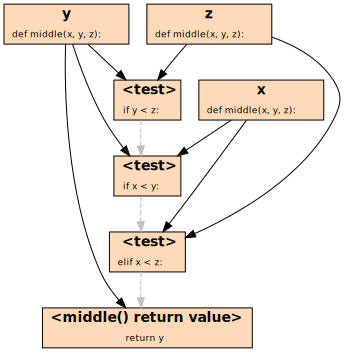

In [86]:
middle_slicer.graph()

In [87]:
print(middle_slicer.dependencies())

middle():
    <test> (2) <= y (1), z (1)
    <test> (3) <= x (1), y (1); <- <test> (2)
    <test> (5) <= x (1), z (1); <- <test> (3)
    <middle() return value> (6) <= y (1); <- <test> (5)



## More Examples

In [88]:
from Assertions import square_root

In [89]:
with Slicer(square_root, log=True) as root_slicer:
    y = square_root(2.0)

Instrumenting <function square_root at 0x7ff217428a60>:
def square_root(x):
    _data.param('x', x)
    assert _data['x'] >= 0
    _data['approx'] = None
    _data['guess'] = _data['x'] / 2
    while _data.test(_data['approx'] != _data['guess']):
        with _data:
            _data['approx'] = _data['guess']
            _data['guess'] = (_data['approx'] + _data['x'] / _data['approx']
                ) / 2
    assert _data.ret(_data.call(_data['math'].isclose)(_data.arg(_data[
        'approx'] * _data['approx']), _data.arg(_data['x'])))
    _data['<square_root() return value>'] = _data['approx']
    return _data['<square_root() return value>']



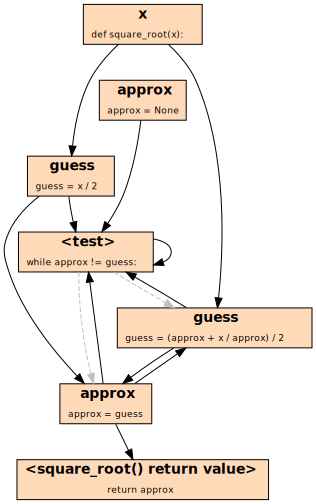

In [90]:
root_slicer.graph()

FIXME: How does `<test>` control itself?

In [91]:
root_slicer.code()

*   51 def square_root(x):
    52     assert x >= 0  # precondition
    53 
*   54     approx = None
*   55     guess = x / 2  # <= x (51)
*   56     while approx != guess:  # <= approx (54), <test> (56), guess (55), guess (58), approx (57)
*   57         approx = guess  # <= guess (55), guess (58); <- <test> (56)
*   58         guess = (approx + x / approx) / 2  # <= x (51), approx (57); <- <test> (56)
    59 
    60     assert math.isclose(approx * approx, x)
*   61     return approx  # <= approx (57)


In [92]:
root_slicer.dependencies()

Dependencies({('x', ('square_root', 51)): set(), ('approx', ('square_root', 54)): set(), ('guess', ('square_root', 55)): {('x', ('square_root', 51))}, ('<test>', ('square_root', 56)): {('approx', ('square_root', 54)), ('<test>', ('square_root', 56)), ('guess', ('square_root', 55)), ('guess', ('square_root', 58)), ('approx', ('square_root', 57))}, ('approx', ('square_root', 57)): {('guess', ('square_root', 55)), ('guess', ('square_root', 58))}, ('guess', ('square_root', 58)): {('x', ('square_root', 51)), ('approx', ('square_root', 57))}, ('<square_root() return value>', ('square_root', 61)): {('approx', ('square_root', 57))}}, {('x', ('square_root', 51)): set(), ('approx', ('square_root', 54)): set(), ('guess', ('square_root', 55)): set(), ('<test>', ('square_root', 56)): set(), ('approx', ('square_root', 57)): {('<test>', ('square_root', 56))}, ('guess', ('square_root', 58)): {('<test>', ('square_root', 56))}, ('<square_root() return value>', ('square_root', 61)): set()})

In [93]:
from Intro_Debugging import remove_html_markup

In [94]:
with Slicer(remove_html_markup) as rhm_slicer:
    s = remove_html_markup("<foo>bar</foo>")

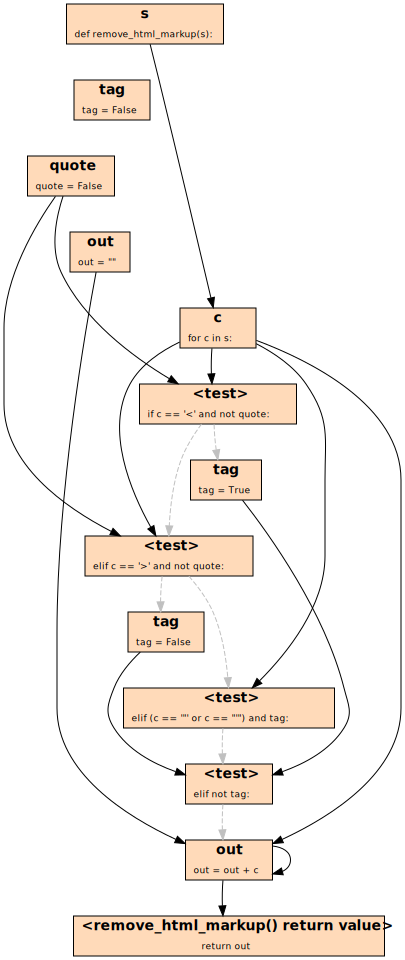

In [95]:
rhm_slicer.graph()

In [96]:
rhm_slicer.code()

*  136 def remove_html_markup(s):
*  137     tag = False
*  138     quote = False
*  139     out = ""
   140 
*  141     for c in s:  # <= s (136)
   142         assert tag or not quote
   143 
*  144         if c == '<' and not quote:  # <= c (141), quote (138)
*  145             tag = True  # <- <test> (144)
*  146         elif c == '>' and not quote:  # <= c (141), quote (138); <- <test> (144)
*  147             tag = False  # <- <test> (146)
*  148         elif (c == '"' or c == "'") and tag:  # <= c (141); <- <test> (146)
   149             quote = not quote
*  150         elif not tag:  # <= tag (147), tag (145); <- <test> (148)
*  151             out = out + c  # <= out (139), c (141), out (151); <- <test> (150)
   152 
*  153     return out  # <= out (151)


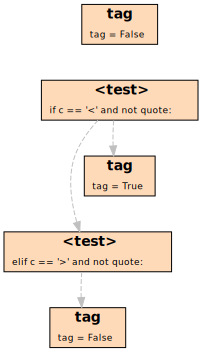

In [97]:
rhm_slicer.dependencies().backward_slice('tag', mode='c').graph()

In [98]:
def add_to(n, m):
    n += m
    return n

In [99]:
def mul_with(x, y):
    x *= y
    return x

In [100]:
def test_math():
    return mul_with(1, add_to(2, 2))

In [101]:
with Slicer(add_to, mul_with, test_math) as math_slicer:
    test_math()

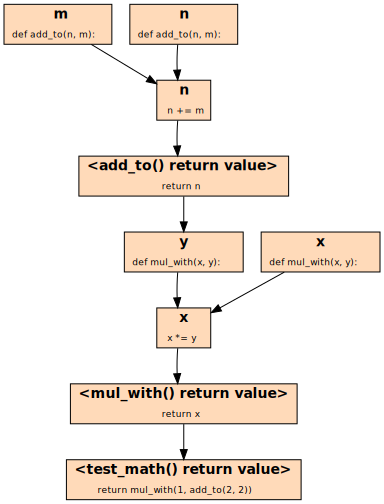

In [102]:
math_slicer.graph()

In [103]:
math_slicer.code()

*    1 def add_to(n, m):
*    2     n += m  # <= n (1), m (1)
*    3     return n  # <= n (2)

*    1 def mul_with(x, y):  # <= <add_to() return value> (add_to:3)
*    2     x *= y  # <= y (1), x (1)
*    3     return x  # <= x (2)

     1 def test_math():
*    2     return mul_with(1, add_to(2, 2))  # <= <mul_with() return value> (mul_with:3)


In [104]:
print(math_slicer.dependencies())

add_to():
    n (2) <= n (1), m (1)
    <add_to() return value> (3) <= n (2)

mul_with():
    y (1) <= <add_to() return value> (add_to:3)
    x (2) <= y (1), x (1)
    <mul_with() return value> (3) <= x (2)

test_math():
    <test_math() return value> (2) <= <mul_with() return value> (mul_with:3)



## Things that do not Work

### Multiple Assignments

In [105]:
def test_multiple_assignment():
    x, y = 0, 1
    t = (x * x, y * y)
    return t[x]

In [106]:
with Slicer(test_multiple_assignment) as multi_slicer:
    test_multiple_assignment()

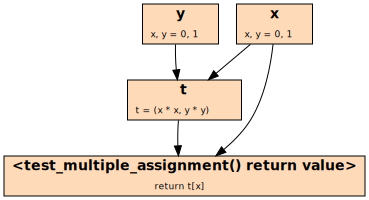

In [107]:
multi_slicer.graph()

### Attributes

In [108]:
class X(object):
    pass

In [109]:
def test_attributes(y):
    x = X()
    x.attr = y
    return x.attr

In [110]:
with Slicer(test_attributes, log=True) as attr_slicer:
    test_attributes(10)

Instrumenting <function test_attributes at 0x7ff2172ead08>:
def test_attributes(y):
    _data.param('y', y)
    _data['x'] = _data.ret(_data.call(_data['X'])())
    _data['x'].attr = _data['y']
    _data['<test_attributes() return value>'] = _data['x'].attr
    return _data['<test_attributes() return value>']



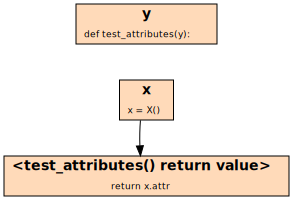

In [111]:
attr_slicer.graph()

TODO: Auto-slice things – in 

```python
with Slicer():
   foo()
```
identify all calls in the code and add them to the instrumentation.

1. Get source code - won't work; will not contain body
2. Use a decorator? (works only for functions...)
3. Replace on the fly – won't work (or will it?), as we cannot change code once it executes

In [112]:
from ExpectError import ExpectError

In [113]:
with ExpectError():
    with Slicer() as slicer:
        y = square_root(9)

Traceback (most recent call last):
  File "<ipython-input-113-04fc5ccbc736>", line 2, in <module>
    with Slicer() as slicer:
  File "<ipython-input-79-bbe3b8c488e4>", line 7, in __init__
    raise ValueError("Need one or more items to instrument")
ValueError: Need one or more items to instrument (expected)


TODO: Create a probabilistic dependence graph for statistical debugging :-)

## Synopsis

_For those only interested in using the code in this chapter (without wanting to know how it works), give an example.  This will be copied to the beginning of the chapter (before the first section) as text with rendered input and output._

## Lessons Learned

* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducer.ipynb)


## Background

_Cite relevant works in the literature and put them into context, as in:_

The idea of ensuring that each expansion in the grammar is used at least once goes back to Burkhardt \cite{Burkhardt1967}, to be later rediscovered by Paul Purdom \cite{Purdom1972}.

@INPROCEEDINGS{6899220,
  author={Z. {Chen} and L. {Chen} and Y. {Zhou} and Z. {Xu} and W. C. {Chu} and B. {Xu}},
  booktitle={2014 IEEE 38th Annual Computer Software and Applications Conference}, 
  title={Dynamic Slicing of Python Programs}, 
  year={2014},
  volume={},
  number={},
  pages={219-228},
  doi={10.1109/COMPSAC.2014.30}
}



## Exercises

_Close the chapter with a few exercises such that people have things to do.  To make the solutions hidden (to be revealed by the user), have them start with_

```
**Solution.**
```

_Your solution can then extend up to the next title (i.e., any markdown cell starting with `#`)._

_Running `make metadata` will automatically add metadata to the cells such that the cells will be hidden by default, and can be uncovered by the user.  The button will be introduced above the solution._

### Exercise 1: _Title_

_Text of the exercise_

In [114]:
# Some code that is part of the exercise
pass

_Some more text for the exercise_

**Solution.** _Some text for the solution_

In [115]:
# Some code for the solution
2 + 2

4

_Some more text for the solution_

### Exercise 2: _Title_

_Text of the exercise_

**Solution.** _Solution for the exercise_